# Appendix B

\begin{align}
\Sigma_t &= \frac{|B_y|^2 \Sigma_0}{t \Sigma_0 + |B_y|^2}\\
\frac{\color{red}{K_2(t)} - \color{red}{K_2(t -1)}}{ dt} &= -\frac{1}{\gamma |B_y|^2 + \alpha \Sigma_t} + \delta \color{red}{K_2(t)} + 2 \frac{\frac{\Sigma_t}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)}{\gamma |B_y|^2 + \alpha \Sigma_t} \color{red}{K_2(t)} +  \frac{\frac{\Sigma_t^2}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)}{\gamma |B_y|^2 + \alpha \Sigma_t} \color{red}{K_2(t)}^2\\
\frac{\color{red}{K_1(t)} - \color{red}{K_1(t-1)}}{dt} &= - \frac{r [1 - K_2 \frac{\Sigma_t}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)]}{\gamma |B_y|^2 + \alpha \Sigma_t} + \delta \color{red}{K_1(t)} +  \frac{[1 + K_2 \Sigma_t] \frac{\Sigma_t}{ |B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)}{\gamma |B_y|^2 + \alpha \Sigma_t} \color{red}{K_1(t)}\\
\frac{\color{red}{K_0(t)} - \color{red}{K_0(t-1)}}{ dt}  &= \delta \color{red}{K_0(t)} - \delta \log \delta + \delta - r - \frac{1}{2} K_2 \frac{\Sigma_t^2}{|B_y|^2} + \frac{1}{2}\left[K_1 \frac{\Sigma_t}{|B_y|^2}\right]^2((\gamma - 1)|B_y|^2 + \alpha \Sigma_t)  - \frac{1}{2}\frac{\left(r +  K_1 \frac{\Sigma_t}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)\right)^2}{\gamma |B_y|^2 + \alpha \Sigma_t}
\end{align}

Terms in front of $z$

$$
0 = \frac{d}{dt}K_1 - \delta K_1 - \frac{\left[1 + K_2 \Sigma\right]\left(\frac{\Sigma}{|B_y|^2}\right) \left[(\gamma - 1) |B_y|^2 + \alpha \Sigma\right]}{\gamma |B_y|^2 + \alpha \Sigma} K_1
$$

In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

In [2]:
Σ0 = 0.1**2
B_y = 0.18
γ = 5
α = 0
δ = 0.01
r = 0.02
T = 100_000
dt = 1

In [3]:
time = np.arange(0, T+dt, dt)
Σt = B_y**2 * Σ0 / (time * Σ0 + B_y**2)

In [4]:
Σt[10]

0.002447129909365559

In [5]:
Σt[T]

3.239895027401112e-07

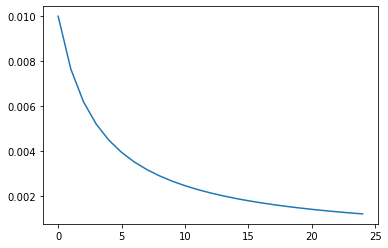

In [6]:
plt.plot(Σt[:25])

In [7]:
@njit
def limiting_K2(args):
    Σ0, B_y, γ, α, δ, r = args
    return 1 / (δ * γ * B_y**2)

@njit
def limiting_K1(args):
    Σ0, B_y, γ, α, δ, r = args
    return r / (δ * γ * B_y**2)

@njit
def limiting_K0(args):
    Σ0, B_y, γ, α, δ, r = args
    return np.log(δ) - 1 + r / δ + 1/2 * r**2 / (δ * γ * B_y**2)

In [8]:
@njit
def simulate_Σ(T, dt, args):
    time = np.arange(0, T+dt, dt)
    Σ0, B_y, γ, α, δ, r = args
    Σt = B_y**2 * Σ0 / (time * Σ0 + B_y**2)
    return Σt

@njit
def simulate_K2(Σt, T, dt, args):
    Σ0, B_y, γ, α, δ, r = args
    adjust = (γ - 1) * B_y**2 + α * Σt
    denominator =  γ * B_y**2 + α * Σt
    # K2
    K2 = np.zeros_like(Σt)
    T_max = len(K2) - 1
    K2[-1] = limiting_K2(args)
    for i in range(1, K2.shape[0]):
        K2[T_max - i] = K2[T_max-i+1]
        K2[T_max - i] += 1 / denominator[T_max-i+1] * dt
        K2[T_max - i] -= δ * K2[T_max-i+1] * dt
        K2[T_max - i] -= 2 * Σt[T_max-i+1] / B_y**2 * adjust[T_max-i+1] / denominator[T_max-i+1] * K2[T_max-i+1] * dt
        K2[T_max - i] -= Σt[T_max-i+1] **2 / B_y**2 * adjust[T_max-i+1] / denominator[T_max-i+1] * K2[T_max-i+1]**2 * dt
    
    return K2

@njit
def simulate_K1(Σt, T, dt, args):
    Σ0, B_y, γ, α, δ, r = args
    K2 = simulate_K2(Σt, T, dt, args)
    adjust = (γ - 1) * B_y**2 + α * Σt
    denominator =  γ * B_y**2 + α * Σt
    T_max = Σt.shape[0] - 1
    # K1
    K1 = np.zeros_like(Σt)
    K1[-1] = limiting_K1(args)
    for i in range(1, K1.shape[0]):
        K1[T_max - i] = K1[T_max - i + 1] 
        K1[T_max - i] += r * (1 - K2[T_max-i+1] * Σt[T_max-i+1] / B_y**2 * adjust[T_max-i+1]) / denominator[T_max-i+1] * dt
        K1[T_max - i] -= δ * K1[T_max-i+1] * dt
        K1[T_max - i] -= (1 + K2[T_max-i+1] * Σt[T_max-i+1]) * Σt[T_max-i+1] / B_y**2 * adjust[T_max-i+1] /denominator[T_max-i+1] * K1[T_max-i+1] * dt
        
    return K2, K1

@njit
def simulate_K0(T, dt, args):
    Σ0, B_y, γ, α, δ, r = args
    Σt = simulate_Σ(T, dt, args)
    K2, K1 = simulate_K1(Σt, T, dt, args)
    adjust = (γ - 1) * B_y**2 + α * Σt
    denominator =  γ * B_y**2 + α * Σt
    T_max = Σt.shape[0] - 1
    # K1
    K0 = np.zeros_like(Σt)
    K0[-1] = limiting_K0(args)
    for i in range(1, K0.shape[0]):
        K0[T_max - i] = K0[T_max - i + 1] - δ * K0[T_max - i + 1] * dt
        K0[T_max - i] += (δ * np.log(δ) - δ + r) * dt
        K0[T_max - i] += 1/2 * K2[T_max-i+1] * Σt[T_max - i + 1]**2 / B_y**2 * dt
        K0[T_max - i] -= 1/2 * (K1[T_max-i+1] * Σt[T_max-i+1] / B_y**2)**2 * adjust[T_max-i+1] * dt
        K0[T_max - i] += 1/2 * (r + K1[T_max-i+1] * Σt[T_max-i+1] / B_y**2 * adjust[T_max-i+1])**2 /denominator[T_max-i+1] * dt
        
    return K2, K1, K0

In [9]:
Σt = simulate_Σ(T, dt, args=(Σ0, B_y, γ, α, δ, r))
K2, K1, K0 = simulate_K0(T, dt, args=(Σ0, B_y, γ, α, δ, r))
K24, K14, K04 = simulate_K0(T, dt, args=(Σ0, B_y, γ, 4., δ, r))
K28, K18, K08 = simulate_K0(T, dt, args=(Σ0, B_y, γ, 8., δ, r))
K2h, K1h, K0h = simulate_K0(T, dt, args=(0.25**2, B_y, γ, α, δ, r))
K24h, K14h, K04h = simulate_K0(T, dt, args=(0.25**2, B_y, γ, 4., δ, r))
K28h, K18h, K08h = simulate_K0(T, dt, args=(0.25**2, B_y, γ, 8., δ, r))
K2l, K1l, K0l = simulate_K0(T, dt, args=(0.05**2, B_y, γ, α, δ, r))
K24l, K14l, K04l = simulate_K0(T, dt, args=(0.05**2, B_y, γ, 4., δ, r))
K28l, K18l, K08l = simulate_K0(T, dt, args=(0.05**2, B_y, γ, 8., δ, r))

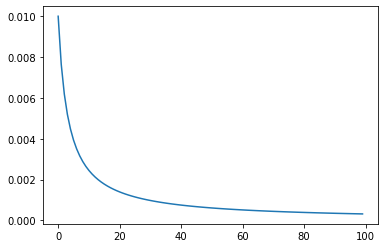

In [10]:
plt.plot(Σt[:100])

In [11]:
# Σ starts at 20, 60, 100
Σ20 = Σt[20]
Σ60 = Σt[60]
Σ100 = Σt[100]
#20
Σt20 = simulate_Σ(T, dt, args=(Σ20, B_y, γ, α, δ, r))
K220, _, _ = simulate_K0(T, dt, args=(Σ20, B_y, γ, α, δ, r))
#60
Σt60 = simulate_Σ(T, dt, args=(Σ60, B_y, γ, α, δ, r))
K260, _, _ = simulate_K0(T, dt, args=(Σ60, B_y, γ, α, δ, r))
#100
Σt100 = simulate_Σ(T, dt, args=(Σ100, B_y, γ, α, δ, r))
K2100, _, _ = simulate_K0(T, dt, args=(Σ100, B_y, γ, α, δ, r))

Text(0.5, 1.0, '$K_2(t)$')

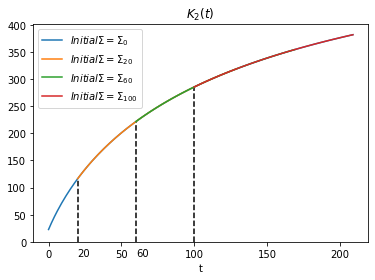

In [12]:
plt.plot(K2[:210], label="$Initial Σ = Σ_{0}$")
plt.plot(np.arange(20,130), K220[:110], label="$Initial Σ = Σ_{20}$")
plt.plot(np.arange(60,170),K260[:110], label="$Initial Σ = Σ_{60}$")
plt.plot(np.arange(100,210),K2100[:110], label="$Initial Σ = Σ_{100}$")
# plt.hlines(y=K220[0], xmin=0, xmax=20, color="black", linestyle="dashed")
plt.vlines(x=20, ymin=0, ymax=K220[0],color="black", linestyle="dashed")
plt.vlines(x=60, ymin=0, ymax=K260[0],color="black", linestyle="dashed")
plt.vlines(x=100, ymin=0, ymax=K2100[0],color="black", linestyle="dashed")
plt.ylim(0)
plt.text(20,-26,"20")
plt.text(60,-26,"60")
plt.legend()
# plt.text(100,-26,"100")
plt.xlabel("t")
plt.title("$K_2(t)$")
# plt.savefig("K2_initiialSigmaExperiment.pdf")

Text(0, 0.5, '$K_2$')

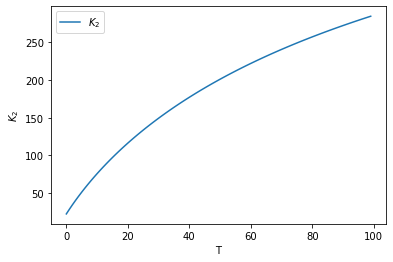

In [13]:
plt.plot(K2[:100], label="$K_2$")
# plt.hlines(y=limiting_K2(args=(Σ0, B_y, γ, α, δ, r)), xmin=0, xmax=T, linestyle="dashed", color="black", label="computed limiting value")
plt.legend()
plt.xlabel("T")
plt.ylabel("$K_2$")
# plt.savefig("K2.pdf")

Text(0, 0.5, '$K_1$')

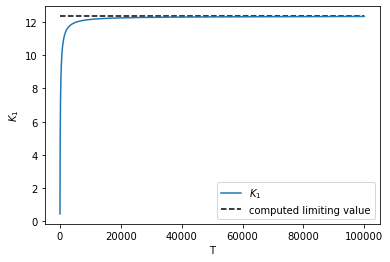

In [14]:
plt.plot(K1, label="$K_1$")
plt.hlines(y=limiting_K1(args=(Σ0, B_y, γ, α, δ, r)), xmin=0, xmax=T, linestyle="dashed", color="black", label="computed limiting value")
plt.legend()
plt.xlabel("T")
plt.ylabel("$K_1$")
# plt.savefig("K2.pdf")

Text(0, 0.5, '$K_1$')

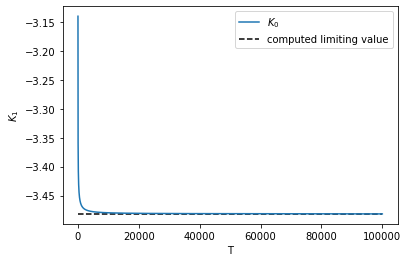

In [15]:
plt.plot(K0, label="$K_0$")
plt.hlines(y=limiting_K0(args=(Σ0, B_y, γ, α, δ, r)), xmin=0, xmax=T, linestyle="dashed", color="black", label="computed limiting value")
plt.legend()
plt.xlabel("T")
plt.ylabel("$K_1$")
# plt.savefig("K2.pdf")

Text(0, 0.5, '$K_0$')

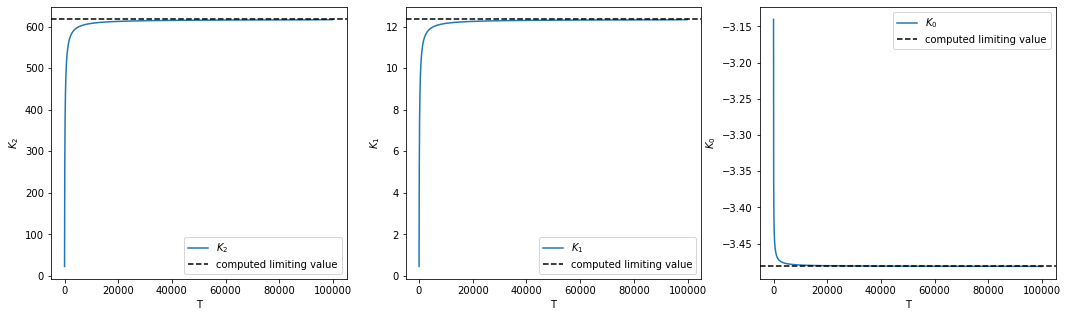

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,5))
ax1.plot(K2, label="$K_2$")
ax1.axhline(y=limiting_K2(args=(Σ0, B_y, γ, α, δ, r)), linestyle="dashed", color="black", label="computed limiting value")
ax1.legend()
ax1.set_xlabel("T")
ax1.set_ylabel("$K_2$")

ax2.plot(K1, label="$K_1$")
ax2.axhline(y=limiting_K1(args=(Σ0, B_y, γ, α, δ, r)), linestyle="dashed", color="black", label="computed limiting value")
ax2.legend()
ax2.set_xlabel("T")
ax2.set_ylabel("$K_1$")

ax3.plot(K0, label="$K_0$")
ax3.axhline(y=limiting_K0(args=(Σ0, B_y, γ, α, δ, r)), linestyle="dashed", color="black", label="computed limiting value")
ax3.legend()
ax3.set_xlabel("T")
ax3.set_ylabel("$K_0$")
# plt.savefig("K2.pdf")

In [17]:
K2[[0,25]], K24[[0,25]], K28[[0,25]]

(array([ 22.66935843, 133.60178322]),
 array([ 19.5935923 , 130.87742794]),
 array([ 17.31936333, 128.27240767]))

In [18]:
K1[[0,25]], K14[[0,25]], K18[[0,25]]

(array([0.45338717, 2.67203566]),
 array([0.39187185, 2.61754856]),
 array([0.34638727, 2.56544815]))

In [19]:
K0[[0,25]], K04[[0,25]], K08[[0,25]]

(array([-3.14015963, -3.3238274 ]),
 array([-3.15591681, -3.32640448]),
 array([-3.16965243, -3.32891847]))

(-3.4, -3.1)

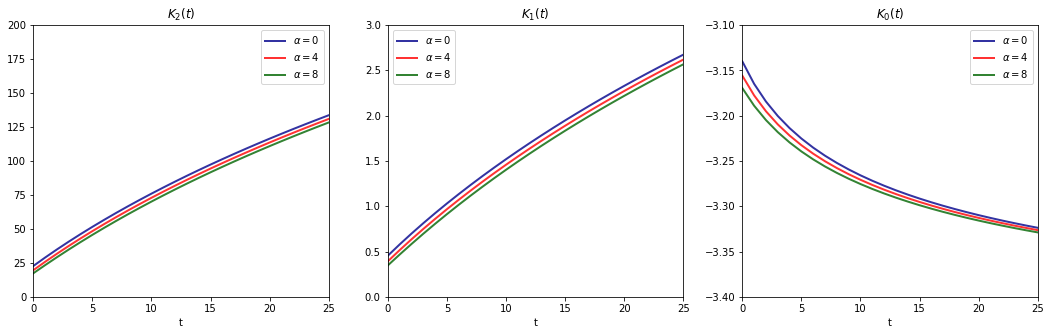

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,5))

ax1.plot(K2, label="$\\alpha=0$", color="darkblue", linewidth=2, alpha=0.8)
ax1.plot(K24, label="$\\alpha=4$", color="red", linewidth=2, alpha=0.8)
ax1.plot(K28, label="$\\alpha=8$", color="darkgreen", linewidth=2, alpha=0.8)
# ax1.axhline(y=limiting_K2(), linestyle="dashed", color="black", label="computed limiting value")
ax1.legend()
ax1.set_xlabel("t")
# ax1.set_ylabel("$K_2$")
ax1.set_title("$K_2(t)$")

ax2.plot(K1, label="$\\alpha=0$", color="darkblue", linewidth=2, alpha=0.8)
ax2.plot(K14, label="$\\alpha=4$", color="red", linewidth=2, alpha=0.8)
ax2.plot(K18, label="$\\alpha=8$", color="darkgreen", linewidth=2, alpha=0.8)
# ax2.axhline(y=limiting_K1(), linestyle="dashed", color="black", label="computed limiting value")
ax2.legend()
ax2.set_xlabel("t")
# ax2.set_ylabel("$K_1$")
ax2.set_title("$K_1(t)$")

ax3.plot(K0, label="$\\alpha=0$", color="darkblue", linewidth=2, alpha=0.8)
ax3.plot(K04, label="$\\alpha=4$", color="red", linewidth=2, alpha=0.8)
ax3.plot(K08, label="$\\alpha=8$", color="darkgreen", linewidth=2, alpha=0.8)
# ax3.axhline(y=limiting_K0(), linestyle="dashed", color="black", label="computed limiting value")
ax3.legend()
ax3.set_xlabel("t")
# ax3.set_ylabel("$K_0$")
ax3.set_title("$K_0(t)$")


ax1.set_xlim(0,25)
ax1.set_ylim(0,200)
ax2.set_xlim(0,25)
ax2.set_ylim(0,3)
ax3.set_xlim(0,25)
ax3.set_ylim(-3.4, -3.1)
# plt.savefig("K25.pdf", bbox_inches="tight")

## Expected excess return, Damage

$$
[\gamma |B_y|^2 + \alpha \Sigma_t] \psi^* = \underbrace{z-r}_{myopic}\quad \underbrace{- [K_1 + K_2 z] \frac{\Sigma_t}{|B_y|^2} \left((\gamma-1) |B_y|^2 + \alpha \Sigma_t \right)}_{hedging}
$$

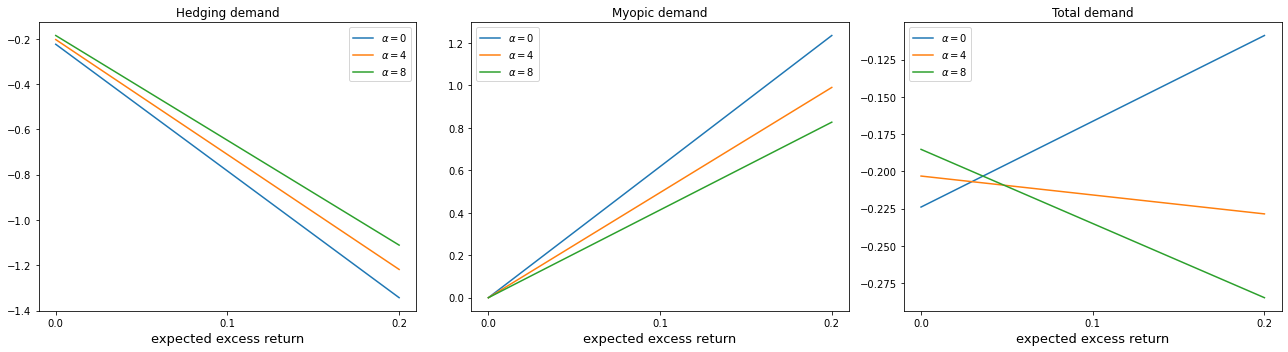

In [21]:
excess = np.linspace(0, 0.2)
z = excess + r
# k1 = K1[0]
# k2 = K2[0]
# k14 = K14[0]
# k24 = K24[0]
# k18 = K18[0]
# k28 = K28[0]


def myopic(z, args):
    Σ0, B_y, γ, α, δ, r = args
    return (z - r) / (γ * B_y**2 + α * Σ0)

def hegding(z, k1, k2, args):
    Σ0, B_y, γ, α, δ, r = args
    adjust = (γ - 1) * B_y**2 + α * Σ0
    temp = -(k1 + k2*z) * Σ0 / B_y**2 * adjust 
    temp /= γ * B_y**2 + α * Σ0
    return temp

myopic0 = myopic(z, args=(Σt[0], B_y, γ, α, δ, r))
myopic4 = myopic(z, args=(Σt[0], B_y, γ, 4., δ, r))
myopic8 = myopic(z, args=(Σt[0], B_y, γ, 8., δ, r))

hedging0 = hegding(z, K1[0], K2[0], args=(Σt[0], B_y, γ, α, δ, r))
hedging4 = hegding(z, K14[0], K24[0], args=(Σt[0], B_y, γ, 4., δ, r))
hedging8 = hegding(z, K18[0], K28[0], args=(Σt[0], B_y, γ, 8., δ, r))

fig,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,5))

ax1.plot(excess, hedging0, label="$\\alpha = 0$")
ax1.plot(excess, hedging4, label="$\\alpha = 4$")
ax1.plot(excess, hedging8, label="$\\alpha = 8$")
ax1.set_title("Hedging demand")

ax2.plot(excess, myopic0, label="$\\alpha = 0$")
ax2.plot(excess, myopic4, label="$\\alpha = 4$")
ax2.plot(excess, myopic8, label="$\\alpha = 8$")
ax2.set_title("Myopic demand")

ax3.plot(excess, myopic0 + hedging0, label="$\\alpha = 0$")
ax3.plot(excess, myopic4 + hedging4, label="$\\alpha = 4$")
ax3.plot(excess, myopic8 + hedging8, label="$\\alpha = 8$")
ax3.set_title("Total demand")

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([0.0, 0.1, 0.2])
    ax.set_xlabel("expected excess return", fontsize=13)
    ax.legend()
    
    
plt.tight_layout()
# plt.savefig("Figure1.pdf")

In [22]:
hedging0[-1] +  myopic0[-1]

-0.10880148719356053

Guess value function

$$
K = x + K_0 + \frac{1}{2}K_2 (z - r)^2
$$

$$
\frac{\color{red}{K_2(t)} - \color{red}{K_2(t -1)}}{ dt} = -\frac{1}{\gamma |B_y|^2 + \alpha \Sigma_t} + \delta \color{red}{K_2(t)} + 2 \frac{\frac{\Sigma_t}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)}{\gamma |B_y|^2 + \alpha \Sigma_t} \color{red}{K_2(t)} +  \frac{\frac{\Sigma_t^2}{|B_y|^2} ((\gamma-1)|B_y|^2 + \alpha \Sigma_t)}{\gamma |B_y|^2 + \alpha \Sigma_t} \color{red}{K_2(t)}^2
$$

$$
0 = \frac{d K_0}{dt} - \delta K_0 + \delta \log \delta - \delta + r + \frac{1}{2} K_2 \frac{\Sigma_t^2}{|B_y|^2}
$$

$$
[\gamma |B_y|^2 + \alpha \Sigma_t] \psi^* = \underbrace{z-r}_{myopic}\quad \underbrace{-  K_2 (z-r) \frac{\Sigma_t}{|B_y|^2} \left((\gamma-1) |B_y|^2 + \alpha \Sigma_t \right)}_{hedging}
$$

In [23]:
@njit
def limiting2_K0():
    return np.log(δ) - 1 + r / δ

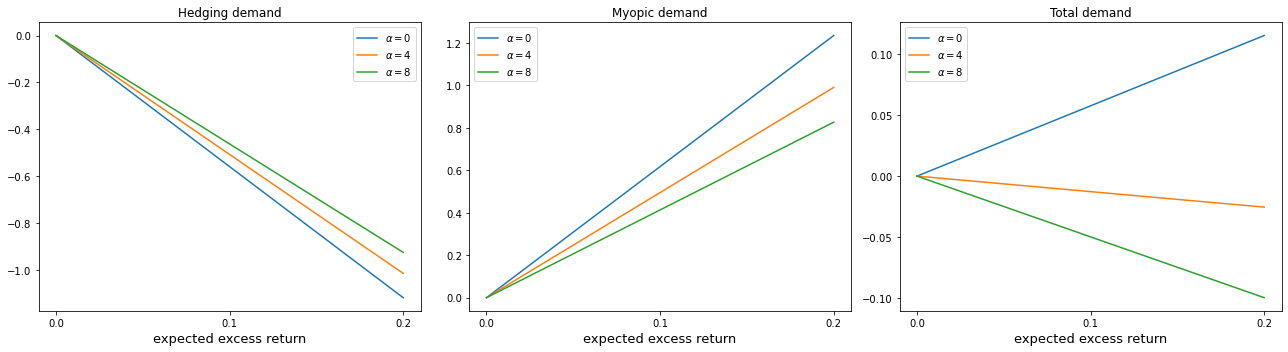

In [29]:
excess = np.linspace(0, 0.2)

def myopic_two(excess, args):
    Σ0, B_y, γ, α, δ, r = args
    return excess / (γ * B_y**2 + α * Σ0)

def hegding_two(excess, k2, args):
    Σ0, B_y, γ, α, δ, r = args
    adjust = (γ - 1) * B_y**2 + α * Σ0
    temp = - k2 * excess * Σ0 / B_y**2 * adjust 
    temp /= γ * B_y**2 + α * Σ0
    return temp

myopic0 = myopic_two(excess, args=(Σt[0], B_y, γ, α, δ, r))
myopic4 = myopic_two(excess, args=(Σt[0], B_y, γ, 4., δ, r))
myopic8 = myopic_two(excess, args=(Σt[0], B_y, γ, 8., δ, r))

hedging0 = hegding_two(excess, K2[0], args=(Σt[0], B_y, γ, α, δ, r))
hedging4 = hegding_two(excess, K24[0], args=(Σt[0], B_y, γ, 4., δ, r))
hedging8 = hegding_two(excess, K28[0], args=(Σt[0], B_y, γ, 8., δ, r))

fig,(ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,5))

ax1.plot(excess, hedging0, label="$\\alpha = 0$")
ax1.plot(excess, hedging4, label="$\\alpha = 4$")
ax1.plot(excess, hedging8, label="$\\alpha = 8$")
ax1.set_title("Hedging demand")

ax2.plot(excess, myopic0, label="$\\alpha = 0$")
ax2.plot(excess, myopic4, label="$\\alpha = 4$")
ax2.plot(excess, myopic8, label="$\\alpha = 8$")
ax2.set_title("Myopic demand")

ax3.plot(excess, myopic0 + hedging0, label="$\\alpha = 0$")
ax3.plot(excess, myopic4 + hedging4, label="$\\alpha = 4$")
ax3.plot(excess, myopic8 + hedging8, label="$\\alpha = 8$")
ax3.set_title("Total demand")

for ax in [ax1, ax2, ax3]:
    ax.set_xticks([0.0, 0.1, 0.2])
    ax.set_xlabel("expected excess return", fontsize=13)
    ax.legend()
    
    
plt.tight_layout()
# plt.savefig("Figure1.pdf")

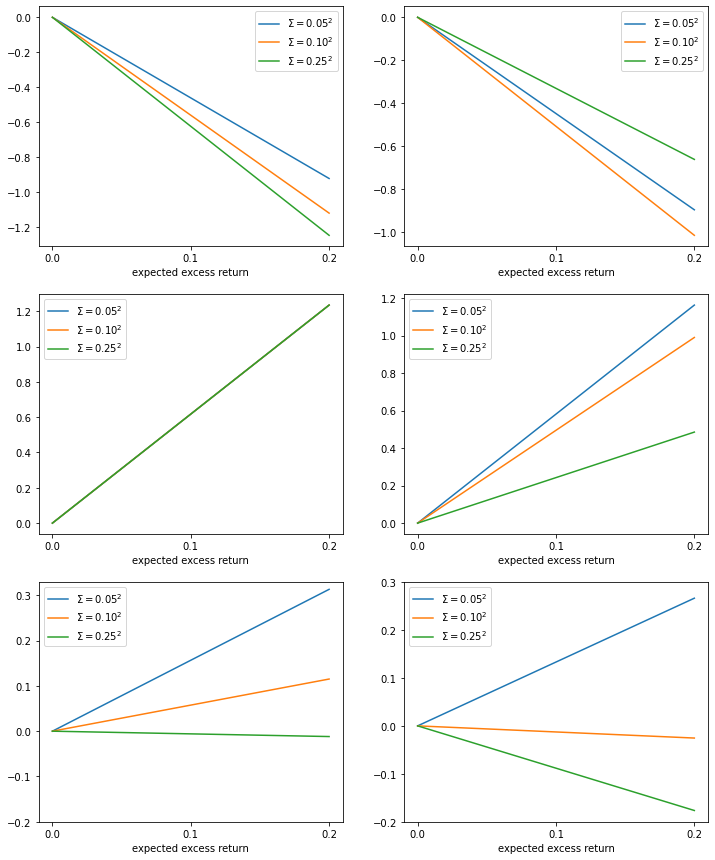

In [48]:
fig, axes = plt.subplots(3,2, figsize=(12, 15))

# DF
## hedging
axes[0,0].plot(excess, hegding_two(excess, K2l[0], args=(0.05**2, B_y, γ, α, δ, r)))
axes[0,0].plot(excess, hegding_two(excess, K2[0], args=(Σt[0], B_y, γ, α, δ, r)))
axes[0,0].plot(excess, hegding_two(excess, K2h[0], args=(0.25**2, B_y, γ, α, δ, r)))
## myopic
axes[1,0].plot(excess, myopic_two(excess, args=(0.05**2, B_y, γ, α, δ, r)))
axes[1,0].plot(excess, myopic_two(excess, args=(Σt[0], B_y, γ, α, δ, r)))
axes[1,0].plot(excess, myopic_two(excess, args=(0.25**2, B_y, γ, α, δ, r)))
## total
axes[2,0].plot(excess, myopic_two(excess, args=(0.05**2, B_y, γ, α, δ, r)) 
               + hegding_two(excess, K2l[0], args=(0.05**2, B_y, γ, α, δ, r)))
axes[2,0].plot(excess, myopic_two(excess, args=(Σt[0], B_y, γ, α, δ, r)) 
               + hegding_two(excess, K2[0], args=(Σt[0], B_y, γ, α, δ, r)))
axes[2,0].plot(excess, myopic_two(excess, args=(0.25**2, B_y, γ, α, δ, r)) 
               + hegding_two(excess, K2h[0], args=(0.25**2, B_y, γ, α, δ, r)))
axes[2,0].set_yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3])

# ambiguity
## hedging
axes[0,1].plot(excess, hegding_two(excess, K24l[0], args=(0.05**2, B_y, γ, 4., δ, r)))
axes[0,1].plot(excess, hegding_two(excess, K24[0], args=(Σt[0], B_y, γ, 4., δ, r)))
axes[0,1].plot(excess, hegding_two(excess, K24h[0], args=(0.25**2, B_y, γ, 4., δ, r)))
## myopic
axes[1,1].plot(excess, myopic_two(excess, args=(0.05**2, B_y, γ, 4., δ, r)))
axes[1,1].plot(excess, myopic_two(excess, args=(Σt[0], B_y, γ, 4., δ, r)))
axes[1,1].plot(excess, myopic_two(excess, args=(0.25**2, B_y, γ, 4., δ, r)))
## total
axes[2,1].plot(excess, myopic_two(excess, args=(0.05**2, B_y, γ, 4., δ, r)) 
               + hegding_two(excess, K24l[0], args=(0.05**2, B_y, γ, 4., δ, r)))
axes[2,1].plot(excess, myopic_two(excess, args=(Σt[0], B_y, γ, 4., δ, r)) 
               + hegding_two(excess, K24[0], args=(Σt[0], B_y, γ, 4., δ, r)))
axes[2,1].plot(excess, myopic_two(excess, args=(0.25**2, B_y, γ, 4., δ, r)) 
               + hegding_two(excess, K24h[0], args=(0.25**2, B_y, γ, 4., δ, r)))
axes[2,1].set_yticks([-0.2, -0.1, 0, 0.1, 0.2, 0.3])


for i in range(axes.shape[0]):
    for j in range(axes.shape[1]):
        axes[i,j].set_xlabel("expected excess return")
        axes[i,j].set_xticks([0,0.1,0.2])
        axes[i,j].legend(["$\\Sigma=0.05^2$", "$\\Sigma=0.10^2$","$\\Sigma=0.25^2$",])